#**Code**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.0 MB/s eta 0:00:00


In [4]:
from tensorflow.keras.utils import img_to_array
from keras_preprocessing.image import load_img
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization,Activation

from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances
import pandas as pd

In [5]:
image_dir = '/content/drive/MyDrive/CSE465/Dataset/mix weather'

# prompt the user to upload an image
from google.colab import files
uploaded = files.upload()

# retrieve the filename of the uploaded image
filename = next(iter(uploaded))

# define the path of the uploaded image
image_path = os.path.join(image_dir, filename)

# save the uploaded image to the image directory
with open(image_path, 'wb') as f:
    f.write(uploaded[filename])

Saving 1.jpeg to 1.jpeg


In [25]:
imgs_path = "/content/drive/MyDrive/CSE465/Dataset/mix weather/"
imgs_model_width, imgs_model_height = 224, 224
nb_closest_images = 10 # number of most similar images to retrieve

#**ResNet101**

In [26]:
from keras.applications import MobileNetV2

convlayer = MobileNetV2(input_shape=(224,224,3),weights='imagenet',include_top=False)

model=Sequential()
model.add(convlayer)
model.add(Flatten())

model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_2 (Flatten)         (None, 62720)             0         
                                                                 
Total params: 2,257,984
Trainable params: 2,223,872
Non-trainable params: 34,112
_________________________________________________________________


In [28]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("flatten_2").output)
feat_extractor.summary()
# print the layers of the CNN


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224_input   [(None, 224, 224, 3)]    0         
 (InputLayer)                                                    
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_2 (Flatten)         (None, 62720)             0         
                                                                 
Total params: 2,257,984
Trainable params: 2,223,872
Non-trainable params: 34,112
_________________________________________________________________


In [29]:
files = [imgs_path + x for x in os.listdir(imgs_path) if "jpg" in x]

print("number of images:",len(files))
print(files)

number of images: 221
['/content/drive/MyDrive/CSE465/Dataset/mix weather/1864.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1834.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1861.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1836.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1882.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1838.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1830.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1866.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1880.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1870.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1840.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1853.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1884.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1850.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weather/1855.jpg', '/content/drive/MyDrive/CSE465/Dataset/mix weat

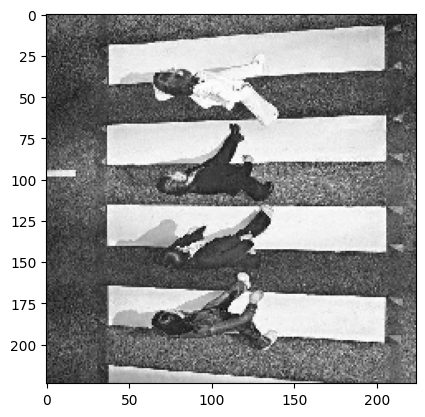

image loaded successfully!


In [30]:
original = load_img(files[-1], target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()
print("image loaded successfully!")

In [31]:
# convert the PIL image to a numpy array
# in PIL - image is in (width, height, channel)
# in Numpy - image is in (height, width, channel)
numpy_image = img_to_array(original)

# convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# we want the input matrix to the network to be of the form (batchsize, height, width, channels)
# thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)

# prepare the image for the RESNET model
processed_image = preprocess_input(image_batch.copy())


image batch size (1, 224, 224, 3)


In [32]:
# get the extracted features
img_features = feat_extractor.predict(processed_image)

print("features successfully extracted!")
print("number of image features:",img_features.size)
img_features

1/1 [==============================] - 2s 2s/step
features successfully extracted!
number of image features: 62720


array([[0.        , 0.        , 0.13388762, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [33]:
importedImages = []

for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    
    importedImages.append(image_batch)
    
images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

In [34]:
# extract the images features

imgs_features = feat_extractor.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape

7/7 [==============================] - 1s 107ms/step
features successfully extracted!


(221, 62720)

#**Cosine Similarity**

In [35]:
# compute cosine similarities between images

cosSimilarities = cosine_similarity(imgs_features)

print(cosSimilarities)
cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
cos_similarities_df.head()

[[1.0000004  0.363886   0.408373   ... 0.27527338 0.20519586 0.31085947]
 [0.363886   0.9999996  0.36054063 ... 0.26515543 0.21726806 0.26164466]
 [0.408373   0.36054063 1.0000008  ... 0.28486335 0.22321147 0.28591692]
 ...
 [0.27527338 0.26515543 0.28486335 ... 0.9999998  0.31436512 0.32802472]
 [0.20519586 0.21726806 0.22321147 ... 0.31436512 1.0000001  0.24421374]
 [0.31085947 0.26164466 0.28591692 ... 0.32802472 0.24421374 1.0000007 ]]


,/content/drive/MyDrive/CSE465/Dataset/mix weather/1864.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1834.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1861.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1836.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1882.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1838.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1830.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1866.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1880.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1870.jpg,...,/content/drive/MyDrive/CSE465/Dataset/mix weather/0852.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0879.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0866.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0883.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0854.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0844.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0849.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0880.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0858.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/beatles.jpg
/content/drive/MyDrive/CSE465/Dataset/mix weather/1864.jpg,1.000000,0.363886,0.408373,0.404946,0.353556,0.265409,0.412308,0.322352,0.281024,0.316218,...,0.294005,0.285644,0.248215,0.274698,0.246375,0.182051,0.277374,0.275273,0.205196,0.310859
/content/drive/MyDrive/CSE465/Dataset/mix weather/1834.jpg,0.363886,1.000000,0.360541,0.397292,0.413742,0.393835,0.373340,0.337513,0.295095,0.402282,...,0.250753,0.299669,0.256290,0.316393,0.254986,0.203244,0.322168,0.265155,0.217268,0.261645
/content/drive/MyDrive/CSE465/Dataset/mix weather/1861.jpg,0.408373,0.360541,1.000001,0.457230,0.375562,0.299715,0.618678,0.409755,0.367304,0.362679,...,0.294198,0.248828,0.202627,0.272792,0.245125,0.184454,0.279015,0.284863,0.223211,0.285917
/content/drive/MyDrive/CSE465/Dataset/mix weather/1836.jpg,0.404946,0.397292,0.457230,1.000000,0.425550,0.350722,0.451481,0.408977,0.322847,0.451311,...,0.371649,0.273501,0.274944,0.317407,0.294068,0.191538,0.347249,0.325342,0.253730,0.323665
/content/drive/MyDrive/CSE465/Dataset/mix weather/1882.jpg,0.353556,0.413742,0.375562,0.425550,1.000000,0.307164,0.439593,0.425420,0.319092,0.388675,...,0.277306,0.329123,0.289442,0.318606,0.264554,0.250496,0.359160,0.300376,0.213425,0.306337


In [36]:
# function to retrieve the most similar products for a given one

def retrieve_most_similar_products(given_img):

    print("-----------------------------------------------------------------------")
    print("original product:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("most similar products:")

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",closest_imgs_scores[i])

In [37]:
retrieve_most_similar_products(files[-1])

Output hidden; open in https://colab.research.google.com to view.

#**Euclidean distance**

In [38]:
from sklearn.metrics.pairwise import pairwise_distances

# compute Euclidean distances between image features
euclidean_distances = pairwise_distances(imgs_features, metric='euclidean')

print(euclidean_distances)
euclidean_distances_df = pd.DataFrame(euclidean_distances, columns=files, index=files)
euclidean_distances_df.head()

[[  0.      328.37418 318.60596 ... 390.96494 343.98022 355.39816]
 [328.37418   0.      315.32794 ... 379.70413 321.93597 351.96295]
 [318.60596 315.32794   0.      ... 376.55832 323.39047 348.25644]
 ...
 [390.96494 379.70413 376.55832 ...   0.      349.87265 375.33835]
 [343.98022 321.93597 323.39047 ... 349.87265   0.      333.9249 ]
 [355.39816 351.96295 348.25644 ... 375.33835 333.9249    0.     ]]


,/content/drive/MyDrive/CSE465/Dataset/mix weather/1864.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1834.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1861.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1836.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1882.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1838.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1830.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1866.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1880.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/1870.jpg,...,/content/drive/MyDrive/CSE465/Dataset/mix weather/0852.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0879.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0866.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0883.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0854.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0844.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0849.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0880.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/0858.jpg,/content/drive/MyDrive/CSE465/Dataset/mix weather/beatles.jpg
/content/drive/MyDrive/CSE465/Dataset/mix weather/1864.jpg,0.000000,328.374176,318.605957,317.718506,355.471161,374.244171,316.843170,348.351593,337.313660,361.038177,...,372.020752,375.776031,361.928467,390.383575,398.168457,395.807434,367.460022,390.964935,343.980225,355.398163
/content/drive/MyDrive/CSE465/Dataset/mix weather/1834.jpg,328.374176,0.000000,315.327942,304.092041,325.708557,326.419556,311.334991,329.079865,316.150757,324.124146,...,368.112152,357.746643,343.272125,365.875977,381.778900,374.635712,341.024109,379.704132,321.935974,351.962952
/content/drive/MyDrive/CSE465/Dataset/mix weather/1861.jpg,318.605957,315.327942,0.000000,290.563080,337.738434,352.541779,244.511490,312.593048,301.934021,336.420776,...,359.386627,372.304047,357.775665,378.858429,386.135681,381.179474,353.699066,376.558319,323.390472,348.256439
/content/drive/MyDrive/CSE465/Dataset/mix weather/1836.jpg,317.718506,304.092041,290.563080,0.000000,322.512115,337.733765,291.327148,310.923340,309.954315,310.761841,...,337.630737,364.302277,338.996643,365.655823,371.979706,377.402832,334.753571,364.361145,314.542084,336.980804
/content/drive/MyDrive/CSE465/Dataset/mix weather/1882.jpg,355.471161,325.708557,337.738434,322.512115,0.000000,373.320679,319.581512,330.452911,340.078888,350.646759,...,386.223389,373.567963,362.694275,387.425140,402.745636,389.121063,355.720978,393.252441,354.911926,366.789093


In [39]:
def retrieve_most_similar_products(given_img):

    print("-----------------------------------------------------------------------")
    print("original product:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("most similar products:")

    closest_imgs = euclidean_distances_df[given_img].sort_values()[1:nb_closest_images+1].index
    closest_imgs_scores = euclidean_distances_df[given_img].sort_values()[1:nb_closest_images+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("Euclidian distance : ",closest_imgs_scores[i])

In [40]:
retrieve_most_similar_products(files[-1])

Output hidden; open in https://colab.research.google.com to view.